<a href="https://colab.research.google.com/github/nicolez9911/colab/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import torch
from torch import nn # nn = building blocks für neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.0.1+cu118'

## Data (preparing & loading)

In [119]:
weight = 0.7
bias = 0.3


start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
print(X[:10], y[:10])

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]) tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


In [120]:
# split data in train & test set
train_split = int(0.8 * len(X))
print(train_split)

40


In [121]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test),  len(y_test)

(40, 40, 10, 10)

## Visualize

In [122]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="training data")

  plt.scatter(test_data, test_labels, c="r", s=4, label="test data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="g", s=4, label="predictions")

  plt.legend(prop={"size": 14})

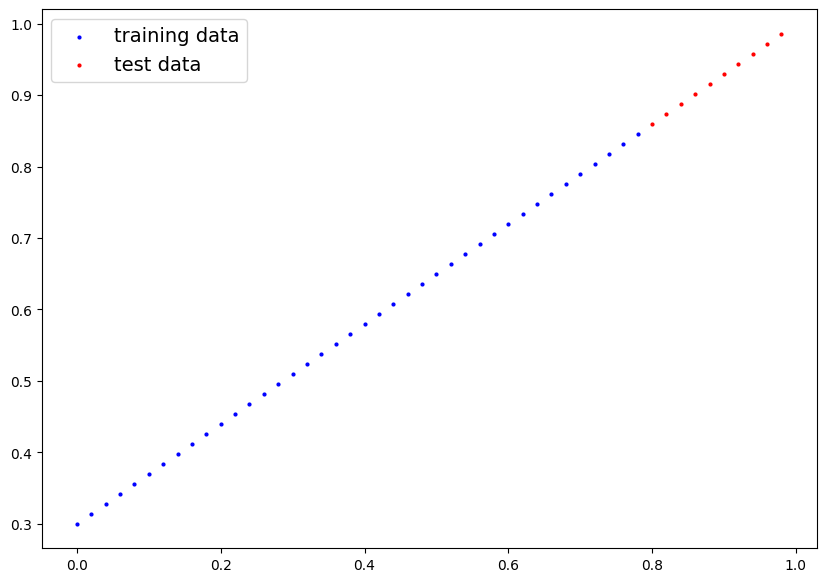

In [123]:
plot_predictions()

## Build the model

In [124]:
# create linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # forward method is required for a nn.Module
  # forward ist die berechnung die dieses modul macht
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

### check the content of the model

In [125]:
# create random seed
torch.manual_seed(42)

# create instance of the model
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [126]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [127]:
weight, bias

(0.7, 0.3)

### making predictions

In [128]:
with torch.inference_mode(): # infrence mode disables the gradient mode, should be faster
  y_preds = model_0(X_test)

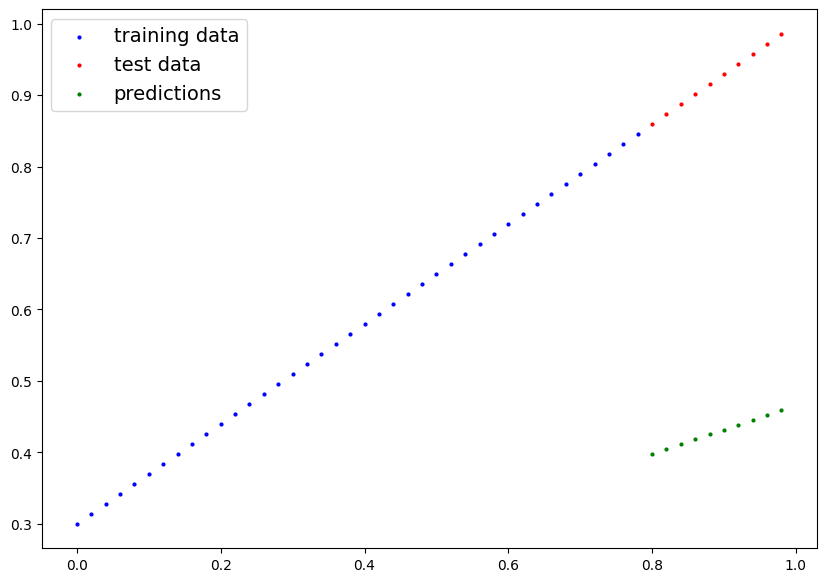

In [129]:
plot_predictions(predictions=y_preds)

### loss function & optimizer

In [130]:
# setup loss function
loss_fn = nn.L1Loss()

# setup optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # learning rate

### building a training & testing loop

In [131]:
epochs = 200

# track values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train()
  model_0.eval()

  # 1. forward pass
  y_pred = model_0(X_train)

  # 2. calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. step the optimizer (perform gradient descent)
  optimizer.step()


  ### Testing
  model_0.eval() # turn on testing mode
  with torch.inference_mode(): # turns off gradient tracking
    # 1. do the forward pass
    test_pred = model_0(X_test)

    # 2. calculate the loss (with test data)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

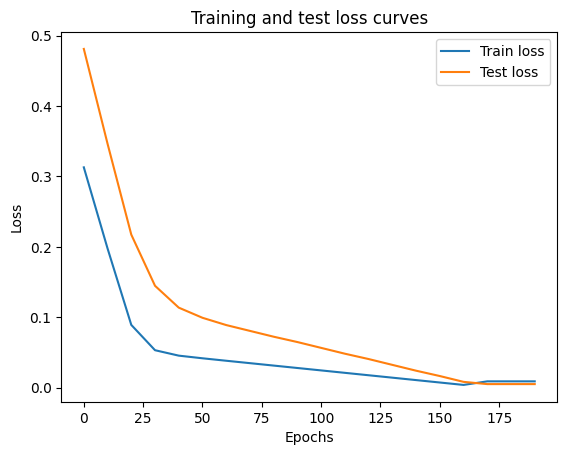

In [132]:
import numpy as np

# plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [133]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [134]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

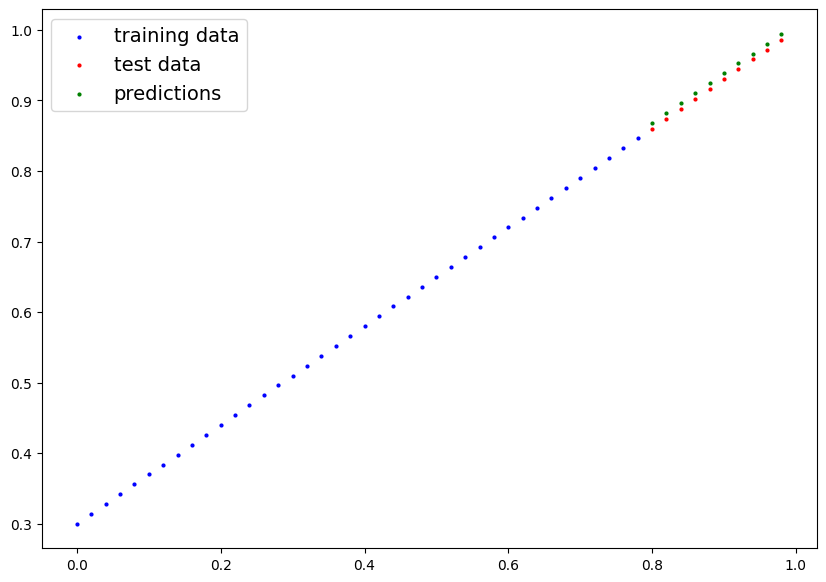

In [135]:
plot_predictions(predictions=y_preds_new)

## Saving a model in pytorch

In [137]:
# recommended => save the state_dict() => darin sind die weights gespeichert
from pathlib import Path

# 1. create directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. save the model state dict
print(f"saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

saving model to models/01_pytorch_workflow_model_0.pth


In [138]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1207 Oct  8 19:05 01_pytorch_workflow_model_0.pth


## Loading a model

In [139]:
# create a new instance of the model to load the saved state in
loaded_model_0 = LinearRegressionModel()

# load the saved state_dict of model_0 (this will update the new instance with the saved parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [144]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [145]:
# make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [146]:
model_0.eval()
with torch.inference_mode():
  model_preds = model_0(X_test)

model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [148]:
model_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])